# Particle Hopping Test - April 7th 2022

Some code to try implementing forward flux for a very simple test system

## Setup

### Imports

In [2]:
import numpy as np

import matplotlib.pyplot as plt

from numba import njit, vectorize, float32

from monk import nb

from typing import Callable, Optional

### Potential

We're going to use a simple quartic potential to emulate a barrier in MD

In [3]:
@vectorize([float32(float32)])
def pot(x):
    x2 = x*x
    return max(2*x2 - x2*x2, 0.0)

SQRT2 = np.sqrt(2.0)

@vectorize([float32(float32)])
def force(x):
    x2 = x*x
    if np.abs(x) < SQRT2:
        return -4*x + 4*x*x2
    else:
        return 0.0

@njit
def force_0(x):
    x2 = x*x
    if np.abs(x) < SQRT2:
        return -4*x + 4*x*x2
    else:
        return 0.0

In [4]:
x = np.linspace(-2, 2, 100, dtype=np.float32)
y = pot(x)
f = force(x)

Text(0.5, 0, '$x$')

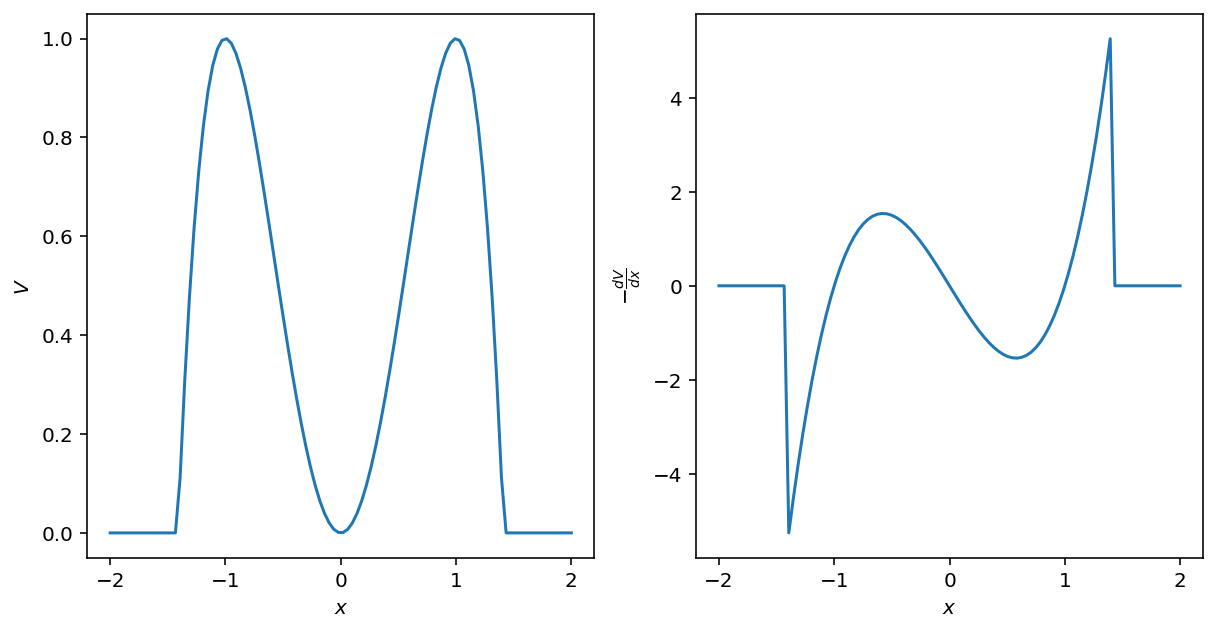

In [45]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

plt.sca(axs[0])
plt.plot(x, y)
plt.ylabel(r"$V$")
plt.xlabel(r"$x$")

plt.sca(axs[1])
plt.plot(x, f)
plt.ylabel(r"$-\frac{dV}{dx}$")
plt.xlabel(r"$x$")

### Order Parameter

Our code is going to call upon an order parameter function to determine how far
along the simulation state is

In [7]:
@njit
def op(x: float):
    return abs(x)

In [8]:
op(-1.0)

1.0

## Simulation

### Class definition

In [328]:
# @njit
# def _lv_step(xi, vi, ws, m, kT, visc):
#     x = xi
#     v = vi
#     for i in range(len(ws)):



class FFTestSim:

    MAX_W_N = 1_000
    QUANT = 0.99

    MAX_STEPS = 100_000_000

    def __init__(
        self, 
        kT: float, 
        rng: np.random.Generator, 
        op: Callable[[float], float],
        force: Callable[[float], float],
        threshold: Optional[float] = None,
        dt: float = 1e-2,
        m: float = 1.0,
        visc: float = 1.0
    ):
        self.x = np.float32(0.0)
        self.kT = np.float32(kT)
        self.rng = rng
        self.op = op
        self.force = force
        if threshold is not None:
            self.threshold = np.float32(threshold)
        else:
            self.threshold = threshold
        self.dt = np.float32(dt)
        self.sqrt_dt = np.sqrt(self.dt)
        self.m = np.float32(m)
        self.visc = np.float32(visc)
        self.v = np.float32(0.0)
        self.out_x = []
        self.out_v = []
        self.out_op = []
        self._basin = None

    def _n_wiener(self, n: int) -> np.ndarray:
        return self.rng.normal(scale=self.sqrt_dt*self.kT, size=n)

    def _langevin_steps(self, ws: np.ndarray, dump=True):
        for w in ws:
            self.v += (-self.visc*self.v*self.dt + self.force(self.x)*self.dt + np.sqrt(2.0*self.visc*self.kT)*w)/self.m
            self.x += self.v*self.dt
            if dump:
                self.out_x.append(self.x)
                self.out_v.append(self.v)
                op_res = self.op(self.x)
                self.out_op.append(op_res)

    def reset(self):
        self.x = np.float32(0.0)
        self.v = np.float32(0.0)

    def reset_out(self):
        self.out_x = []
        self.out_v = []
        self.out_op = []

    def run(self, steps: int):
        ws = self._n_wiener(steps)
        self._langevin_steps(ws)

    def _bootstrap_ff(self, ws: np.ndarray):
        ff_states = []
        last_op_res = 0.0
        for w in ws:
            self.v += (-self.visc*self.v*self.dt + self.force(self.x)*self.dt + np.sqrt(2.0*self.visc*self.kT)*w)/self.m
            self.x += self.v*self.dt
            op_res = self.op(self.x)
            if op_res > self.basin and last_op_res < self.basin:
                ff_states.append((self.x, self.v))
            last_op_res = op_res

        return ff_states

    def _run_ff_trails(self, state, trials, barrier):
        # print(state, trials, barrier)
        passed_trials = []
        for trial in range(trials):
            # print("subtrial:", trial)
            self.x = state[0]
            self.v = state[1]
            trial_done = False
            while not trial_done:
                ws = self._n_wiener(self.MAX_W_N)
                for w in ws:
                    self.v += (-self.visc*self.v*self.dt + self.force(self.x)*self.dt + np.sqrt(2.0*self.visc*self.kT)*w)/self.m
                    self.x += self.v*self.dt
                    op_res = self.op(self.x)
                    if op_res < self.basin:
                        trial_done = True
                        break
                    elif op_res > barrier:
                        trial_done = True
                        passed_trials.append((self.x, self.v))
                        break
        
        return passed_trials
                    
    
    def run_ff(self, samples: int, trials: int, barrier_step: float, thermalize_steps=1000):
        if self.basin is None:
            raise RuntimeError("'self.basin' was not set")

        self.reset()
        
        # Collecting starting points for trajectory
        ws = self._n_wiener(thermalize_steps)
        self._langevin_steps(ws, dump=False)

        n = 0
        ff_states = []
        while True:
            ws = self._n_wiener(self.MAX_W_N)

            new_states = self._bootstrap_ff(ws)
            ff_states.extend(new_states)

            n += self.MAX_W_N

            if len(ff_states) >= samples:
                ff_states = ff_states[:samples]
                break

            if n > self.MAX_STEPS:
                raise RuntimeError("Max number of simulation steps have been reached")

        # iterate over found samples

        time = n*self.dt
        base_rate = len(ff_states)/time

        out_states = []
        fluxes = []
        barriers = []
        for idx, state in enumerate(ff_states):
            print("state:", idx)
            barrier = self.basin
            state_flux = []
            last_trial_set = [state]
            states = [state]
            while True:
                barrier += barrier_step
                # print("barrier:", barrier)
                if idx == 0:
                    barriers.append(barrier)
                done_with_sub_barrier = False
                used_trials = 0
                while not done_with_sub_barrier:
                    state = self.rng.choice(last_trial_set)
                    passed_trials = self._run_ff_trails(state, trials, barrier)
                    num_passed_trials = len(passed_trials)
                    # print("passed trials:", num_passed_trials)
                    used_trials = trials
                    if num_passed_trials > 0:
                        states.append(state)
                        last_trial_set = passed_trials
                        state_flux.append(num_passed_trials/used_trials)
                        done_with_sub_barrier = True
                
                if barrier > 1.1:  # arbitrary
                    break
            fluxes.append(state_flux)
            out_states.append(states)
            
        return base_rate, fluxes, barriers, out_states

    @property
    def basin(self):
        return self._basin

    @basin.setter
    def basin(self, value: float):
        self._basin = value

    def sample_basin(self, steps: int, quant: float = 0.99) -> float:

        if quant <= 0.0 or quant >= 1.0:
            raise ValueError("'quant' must be in the range (0.0, 1.0)")

        self.reset()
        self.reset_out()

        thres = self.threshold

        ws = self._n_wiener(steps)
        for w in ws:
            x = self.x
            self.x += self.v*self.dt
            self.v += (-self.visc*self.v*self.dt + self.force(x)*self.dt + np.sqrt(2.0*self.visc*self.kT)*w)/self.m
            self.out_x.append(self.x)
            self.out_v.append(self.v)
            op_res = self.op(self.x)
            self.out_op.append(op_res)
            # if thres is not None and op_res >= thres:
    
        return np.quantile(self.out_op, quant)




### Testing

In [273]:
rng = np.random.default_rng()

In [274]:
sim = FFTestSim(0.45, rng, op, lambda x: 0.0, threshold=1.0, dt=0.1)
sim.run(100_000)

In [275]:
from scipy.stats import norm as sp_norm

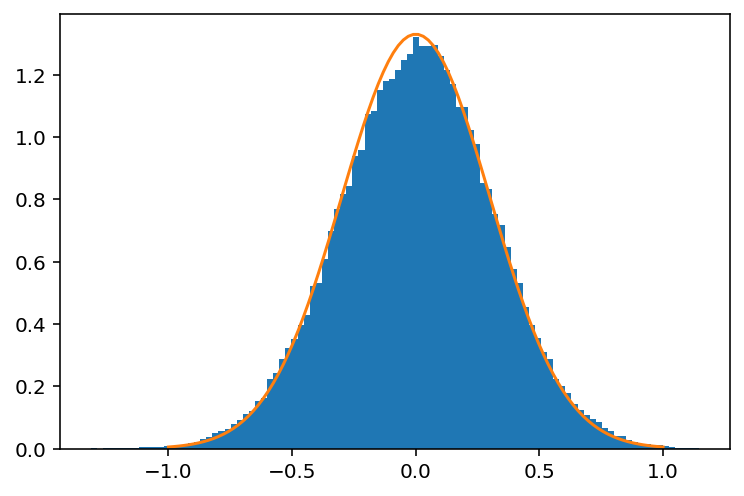

In [276]:
plt.hist(sim.out_v, bins=100, density=True);
x = np.linspace(-1.0, 1.0, 100)
rv = sp_norm(scale=0.3)
plt.plot(x, rv.pdf(x))

In [347]:
sim = FFTestSim(0.40, rng, op, force_0, threshold=1.0, dt=0.1)

In [348]:
sim.basin = sim.sample_basin(10_000, quant=0.99)

In [349]:
sim.x

-0.017899228429012825

In [350]:
sim.basin

0.4205985340429759

In [351]:
ff_data = sim.run_ff(100, 1000, 0.05)

state: 0
state: 1
state: 2
state: 3
state: 4
state: 5
state: 6
state: 7
state: 8
state: 9
state: 10
state: 11
state: 12
state: 13
state: 14
state: 15
state: 16
state: 17
state: 18
state: 19
state: 20
state: 21
state: 22
state: 23
state: 24
state: 25
state: 26
state: 27
state: 28
state: 29
state: 30
state: 31
state: 32
state: 33
state: 34
state: 35
state: 36
state: 37
state: 38
state: 39
state: 40
state: 41
state: 42
state: 43
state: 44
state: 45
state: 46
state: 47
state: 48
state: 49
state: 50
state: 51
state: 52
state: 53
state: 54
state: 55
state: 56
state: 57
state: 58
state: 59
state: 60
state: 61
state: 62
state: 63
state: 64
state: 65
state: 66
state: 67
state: 68
state: 69
state: 70
state: 71
state: 72
state: 73
state: 74
state: 75
state: 76
state: 77
state: 78
state: 79
state: 80
state: 81
state: 82
state: 83
state: 84
state: 85
state: 86
state: 87
state: 88
state: 89
state: 90
state: 91
state: 92
state: 93
state: 94
state: 95
state: 96
state: 97
state: 98
state: 99


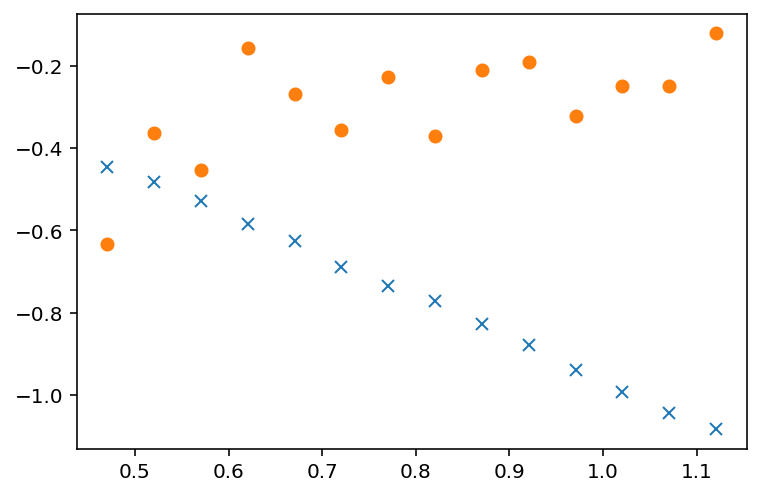

In [370]:
idx = 0
pos = [x[0] for x in ff_data[3][idx]]
vel = [x[1] for x in ff_data[3][idx]]

plt.plot(ff_data[2], pos[1:], "x")

plt.plot(ff_data[2], vel[1:], "o")

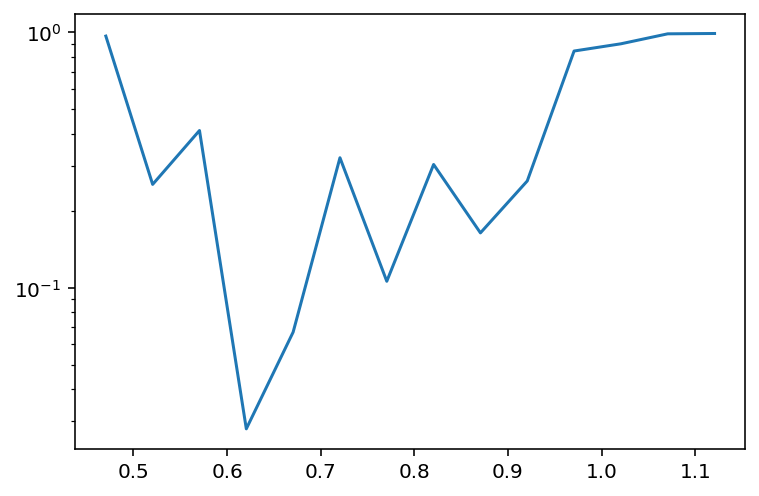

In [375]:
plt.plot(ff_data[2], ff_data[1][idx])
plt.yscale('log')

In [355]:
ff_data[0]

0.004807692236052111

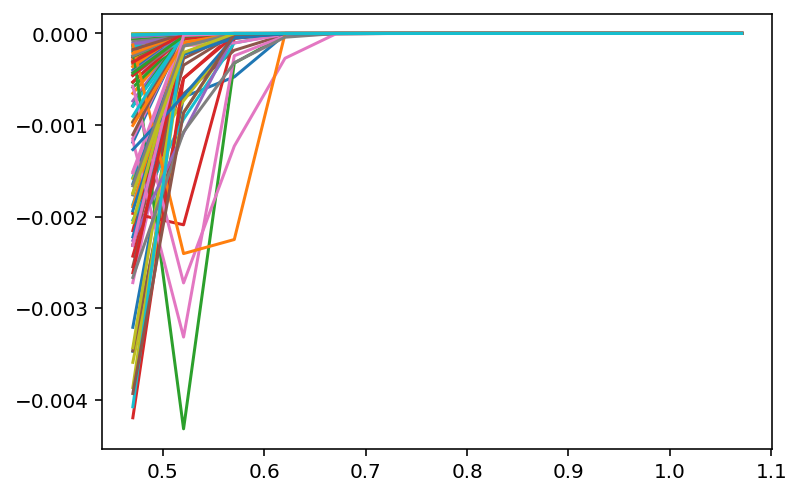

In [359]:
for ff in ff_data[1]:
    rate = ff_data[0]
    curve = []
    for f in ff:
        rate *= f
        curve.append(rate)
    plt.plot(ff_data[2][:-1], np.diff(curve))
# plt.yscale('log')

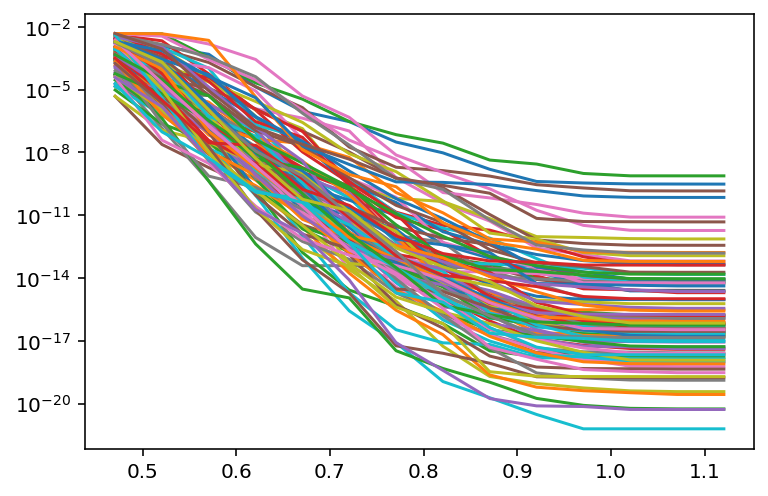

In [361]:
for ff in ff_data[1]:
    rate = ff_data[0]
    curve = []
    for f in ff:
        rate *= f
        curve.append(rate)
    plt.plot(ff_data[2], curve)
plt.yscale('log')

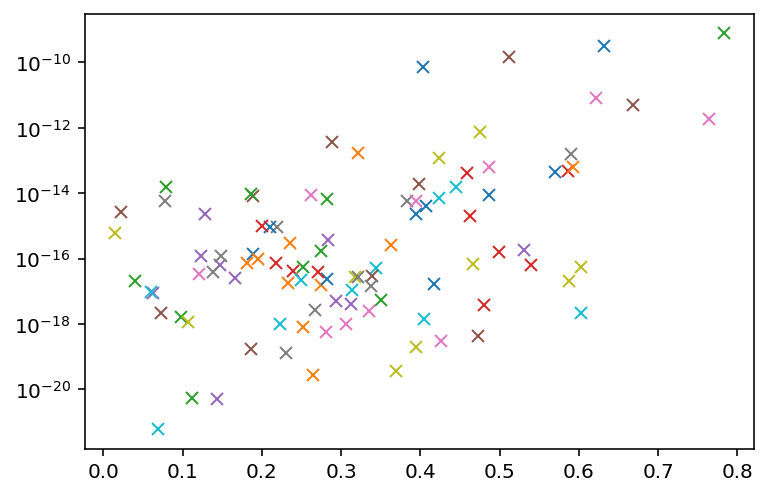

In [383]:
for i, ff in enumerate(ff_data[1]):
    rate = ff_data[0]
    curve = []
    for f in ff:
        rate *= f
        curve.append(rate)
    plt.plot(np.abs(ff_data[3][i][0][1]), curve[-1], "x")
plt.yscale('log')

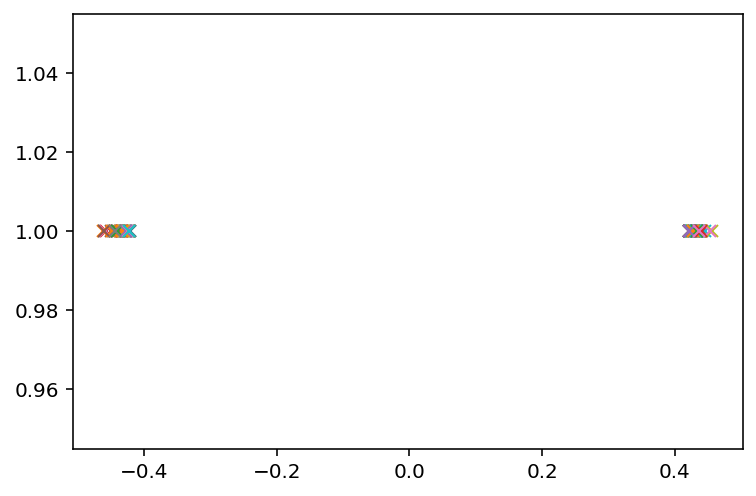

In [369]:
for ff in ff_data[3]:
    tmp = ff[0]
    plt.plot(tmp[0], np.sign(tmp[0]*tmp[1]), "x")

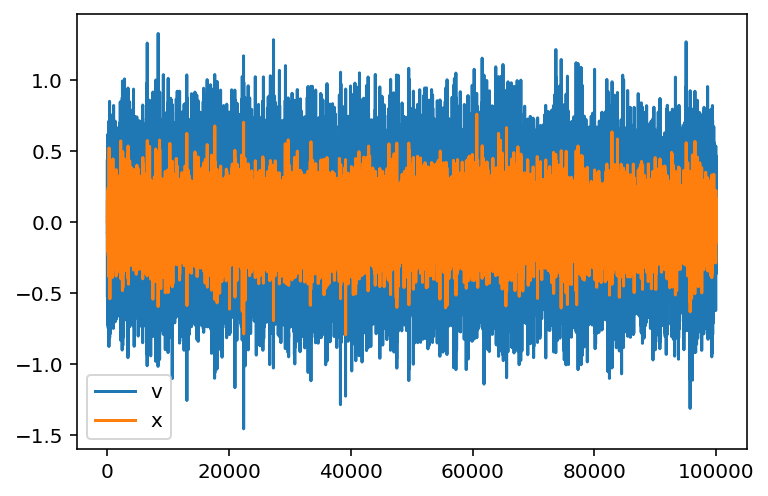

In [57]:
plt.plot(sim.out_v, label="v");
plt.plot(sim.out_x, label="x");
plt.legend()

In [52]:
sim.out_op

[]

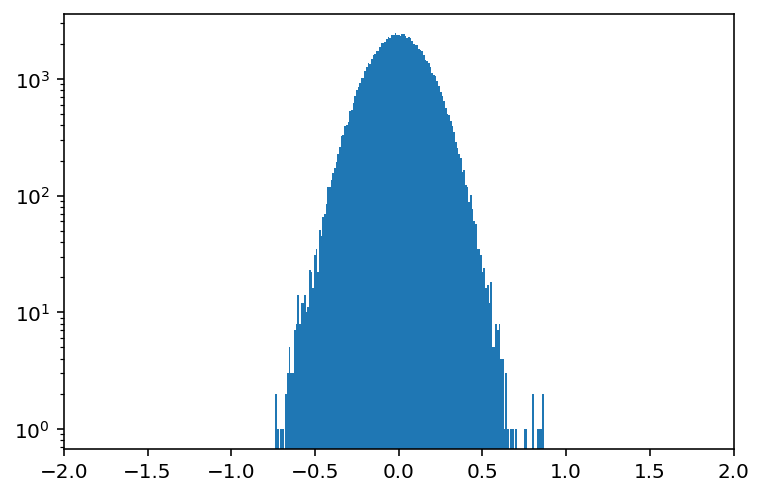

In [130]:
plt.hist(sim.out_x, bins=np.linspace(-2.0, 2.0, 400))
plt.xlim(-2.0, 2.0)
plt.yscale('log')

(0.0, 2.0)

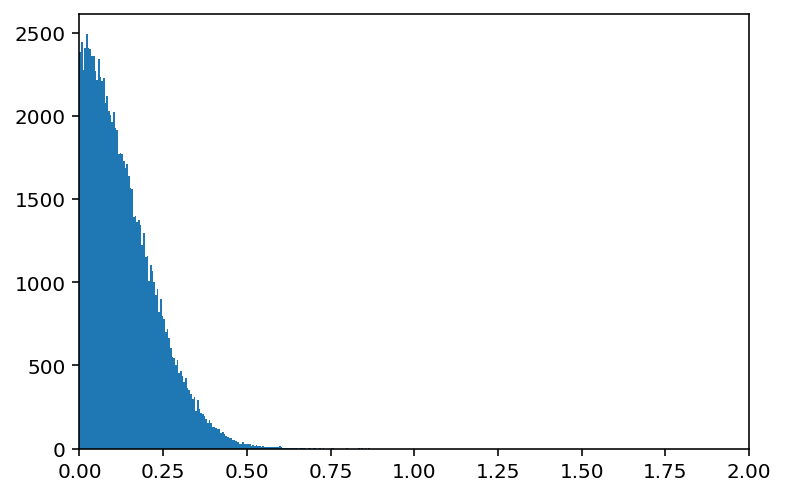

In [135]:
plt.hist(sim.out_op, bins=np.linspace(0.0, 2.0, 400))
plt.xlim(0.0, 2.0)
# plt.yscale('log')

In [136]:
np.quantile(sim.out_op, 0.99)

0.43352255471649526

In [54]:
data = []
kTs = np.linspace(0.05, 0.4, 8)
for kT in kTs:
    sim = FFTestSim(kT, rng, op, force_0, threshold=1.0, dt=0.1)
    sim.run(100_000)
    data.append(np.max(sim.out_x))

(0.0, 1.0)

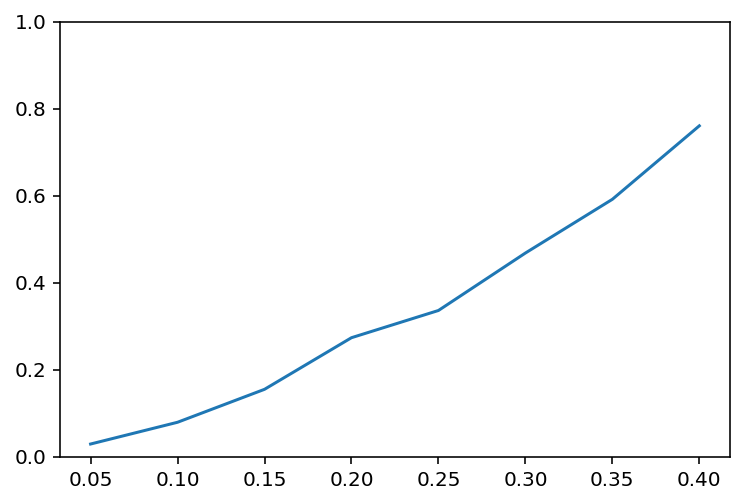

In [55]:
plt.plot(kTs, data)
# plt.yscale('log')
plt.ylim(0.0, 1.0)